## Modules

In [1]:
from llama_index import SimpleDirectoryReader, VectorStoreIndex, ServiceContext, StorageContext, set_global_service_context
from llama_index.node_parser import SimpleNodeParser
from llama_index.text_splitter import TokenTextSplitter
from llama_index.storage.docstore import SimpleDocumentStore
from llama_index.storage.index_store import SimpleIndexStore
from llama_index.vector_stores import SimpleVectorStore

from transformers import AutoTokenizer
from langchain.embeddings import HuggingFaceEmbeddings
from datasets import Dataset
import os
import json
from ragas.metrics.context_precision import ContextPrecision
from datasets import Dataset
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

## Experiment
1. Take batches of training question
2. Load documents associated with it
3. Chunk (chunk size per batch) -> 256,356,..
4. Retreive
5. Score
6. If AP < 0.5 store 

## Playground

In [47]:
reader = SimpleDirectoryReader("./wikidata/")
data = reader.load_data()[:50]

In [2]:
tokenizer = AutoTokenizer.from_pretrained("BAAI/bge-small-en-v1.5",trucation_side='left')

In [3]:
tokenizer.truncation_side = "left"
tokenizer.model_max_length = 512


In [4]:


token_splitter = TokenTextSplitter(chunk_size=356
                                   , chunk_overlap=26, tokenizer=tokenizer.encode)
node_parser = SimpleNodeParser.from_defaults(text_splitter=token_splitter)

In [5]:
embed_model = HuggingFaceEmbeddings(model_name="BAAI/bge-small-en-v1.5")


In [6]:

# create storage context using default stores
storage_context = StorageContext.from_defaults(
    docstore=SimpleDocumentStore(),
    vector_store=SimpleVectorStore(),
    index_store=SimpleIndexStore(),
)

In [7]:
# nodes = node_parser.get_nodes_from_documents(data)

In [8]:
service_context = ServiceContext.from_defaults(node_parser=node_parser, embed_model=embed_model,)

In [9]:
set_global_service_context(service_context)

In [55]:
index = VectorStoreIndex.from_documents(data, storage_context=storage_context, service_context=service_context) 

In [34]:
index.storage_context.persist(persist_dir="sample.index")


In [56]:
retreiver = index.as_retriever()

In [57]:
retreiver.similarity_top_k = 6

In [58]:
chunks = retreiver.retrieve("What can you tell me about Gary Cherone?")

In [59]:
dataset = Dataset.from_json("/home/shahul/data/qrecc-training.json")

In [117]:
def prepare_query(item):
    context, question = item['Context'], item["Question"]
    query = "\n".join(context) + tokenizer.sep_token + question
    query = tokenizer.decode(tokenizer.encode(query,max_length=512,truncation=True, add_special_tokens=False))
    return query 
    

In [142]:
item = dataset[13]

In [143]:
query = prepare_query(item)
print(query)

what is mmm? mmm is the debut mixtape by puff daddy, originally released on november 4, 2015 as a free mixtape on bad boy records and epic records. [SEP] is it an album or a song?


In [136]:
chunks = retreiver.retrieve(query)

In [137]:
eval_query = item["Rewrite"]

In [159]:
dict = {"question":eval_query,
        "contexts":[node.get_content() for node in chunks],}

In [160]:
context_precision = ContextPrecision()

In [161]:
results = context_precision.score_single(dict)

In [162]:
results

0.0

## Data analysis
- after `rag.py`

In [2]:
data = Dataset.from_json("wikidata/indices/subset.json")

(array([1446.,  309.,  198.,  263.,  280.,  116.,  191.,  146.,  152.,
         400.]),
 array([0. , 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. ]),
 <BarContainer object of 10 artists>)

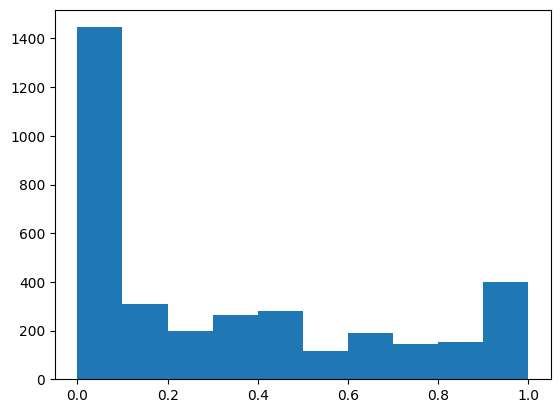

In [3]:
plt.hist(data["ragas_score"])

In [4]:
sum(np.array(data["ragas_score"]) < 0.5)

2496

In [34]:
# best_samples = data.filter(lambda ex: ex["ragas_score"]<0.5)

In [35]:
# best_samples[0]

In [12]:
from llama_index import load_index_from_storage, load_indices_from_storage, load_graph_from_storage


In [7]:
datapath="./sample-0.index/"
# create storage context using default stores
storage_context = StorageContext.from_defaults(
    docstore=SimpleDocumentStore.from_persist_dir(persist_dir=datapath),
    vector_store=SimpleVectorStore.from_persist_dir(persist_dir=datapath),
    index_store=SimpleIndexStore.from_persist_dir(persist_dir=datapath),
)

In [28]:
index = load_index_from_storage(storage_context)


In [29]:
retriever = index.as_retriever(similarity_top_k=10)

- load document from index
- search for positve chunk using Answer
- add positive/negative chunks to form dataset
   - verify positives using llm call
   - query,context,pos,neg

In [17]:
from ragas.metrics.critique import AspectCritique

In [19]:
critic = AspectCritique(name="filter", definition="Does the submission contain information that can be derived from input?")

In [22]:
item=finetuning_dataset[0]
critic.score_single({"question":item[""][0],"answer":item["Answer"]})

0

In [16]:
len(dataset.filter(lambda ex: ex["ragas_score"]<=0.8))

Filter:   0%|          | 0/3501 [00:00<?, ? examples/s]

2949

In [28]:
dataset = Dataset.from_json("wikidata/indices/subset.json")
batch_size=100
max_ragas_score = 0.8
threshold=0.8
finetuning_dataset = []
for batch in tqdm(range(0,200, batch_size)):
    datapath=f"./sample-{batch}.index/"
    # create storage context using default stores
    storage_context = StorageContext.from_defaults(
        docstore=SimpleDocumentStore.from_persist_dir(persist_dir=datapath),
        vector_store=SimpleVectorStore.from_persist_dir(persist_dir=datapath),
        index_store=SimpleIndexStore.from_persist_dir(persist_dir=datapath),
    )
    set_global_service_context(service_context)
    index = load_index_from_storage(storage_context)
    retriever = index.as_retriever(similarity_top_k=1)
    subsample = dataset.select(range(batch, batch+batch_size))
    try:
        for item in subsample:
            if item["ragas_score"] <= max_ragas_score:
    
                node = retriever.retrieve(item["Answer"])[0]
                # filter = critic.score_single({"question":node.get_content(),"answer":item["Answer"]})

                if node.get_score()>=threshold:
                # if filter:
                    pos_chunk = node.to_dict()
                else:
                    continue

                
    
                retrieved_chunks = item["chunks"]
                # hard negatives : till positive hash
                hard = True
                hard_negatives,negatives = [], []
                for node in retrieved_chunks:
    
                    if node["node"]["hash"] == pos_chunk["node"]["hash"]:
                        hard = False
    
                    if hard:
                        hard_negatives.append(node)
                    else:
                        negatives.append(node)
    
                sample = {"Question":item["Question"], "Answer":item["Answer"],
                        "positives":[pos_chunk["node"]["text"]],
                        "negatives":[chunk["node"]["text"] for chunk in negatives],
                        "hard_negatives":[chunk["node"]["text"] for chunk in hard_negatives]}
                finetuning_dataset.append(sample)
    except Exception as e:
        print(e)
            
            
        

100%|█████████████████████████████████████████████████████| 2/2 [00:34<00:00, 17.29s/it]


In [30]:
len(finetuning_dataset)

21